In [1]:
import time
import glob as glob
from zipfile import ZipFile
from bs4 import BeautifulSoup
import dateutil.parser as dparser
import datetime
import pandas as pd
import multiprocessing as mp
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
from sortedcontainers import SortedSet
import statistics
import operator
from statsmodels.distributions.empirical_distribution import ECDF

%matplotlib inline

## Set types and drop useless data

In [2]:
df = pd.read_csv('/home/shane/Documents/thesis/output/final/failures2.csv', parse_dates=['timestamp_dir'])
df['operational_pct'] = df['operational_pct'].astype('float') * 100
df['partial_pct'] = df['partial_pct'].astype('float') * 100
df['major_pct'] = df['major_pct'].astype('float') * 100
df['maint_pct'] = df['maint_pct'].astype('float') * 100
df.drop(['timestamp_site'], axis=1, inplace=True)
df.dropna(inplace=True)

## Mean aggregation by hour

In [3]:
df['date'] = df.timestamp_dir.dt.date
df['time'] = df.timestamp_dir.dt.time
df['hour'] = df.timestamp_dir.dt.hour
df_grp = df.reset_index().groupby(['service','date','hour']).agg({'operational_pct': 'mean', 'partial_pct': 'mean', 'major_pct': 'mean', 'maint_pct': 'mean'})

In [4]:
# timeseries['operational_pct'].columns.tolist()
cols = ['Access (Atlassian)',
 'Airbnb',
 'Amazon',
 'Bitbucket',
 'Blogger',
 'Cloudflare',
 'Confluence',
 'Developers (Atlassian)',
 'Discord',
 'Facebook',
 'Foursquare',
 'GitHub',
 'Gmail',
 'Google Cloud',
 'Hotmail',
 'Jira Align',
 'Jira Core',
 'Jira Service Desk',
 'Jira Software',
 'LinkedIn',
 'LiveJournal',
 'Lyft',
 'Netflix',
 'Ning',
 'Opsgenie',
 'Partners (Atlassian)',
 'PayPal',
 'Pinterest',
 'Reddit',
 'Skype',
 'Slack',
 'Snapchat',
 'Spotify',
 'Statuspage',
 'Support (Atlassian)',
 'Trello',
 'Tumblr',
 'Twitter',
 'Typepad',
 'Yahoo! Mail',
 'YouTube',
 'Zynga']

## Distribution of means (ECDF)

In [5]:
timeseries = df_grp.reset_index().pivot(index=['date','hour'], columns=['service'], values=['operational_pct','partial_pct','major_pct','maint_pct'])

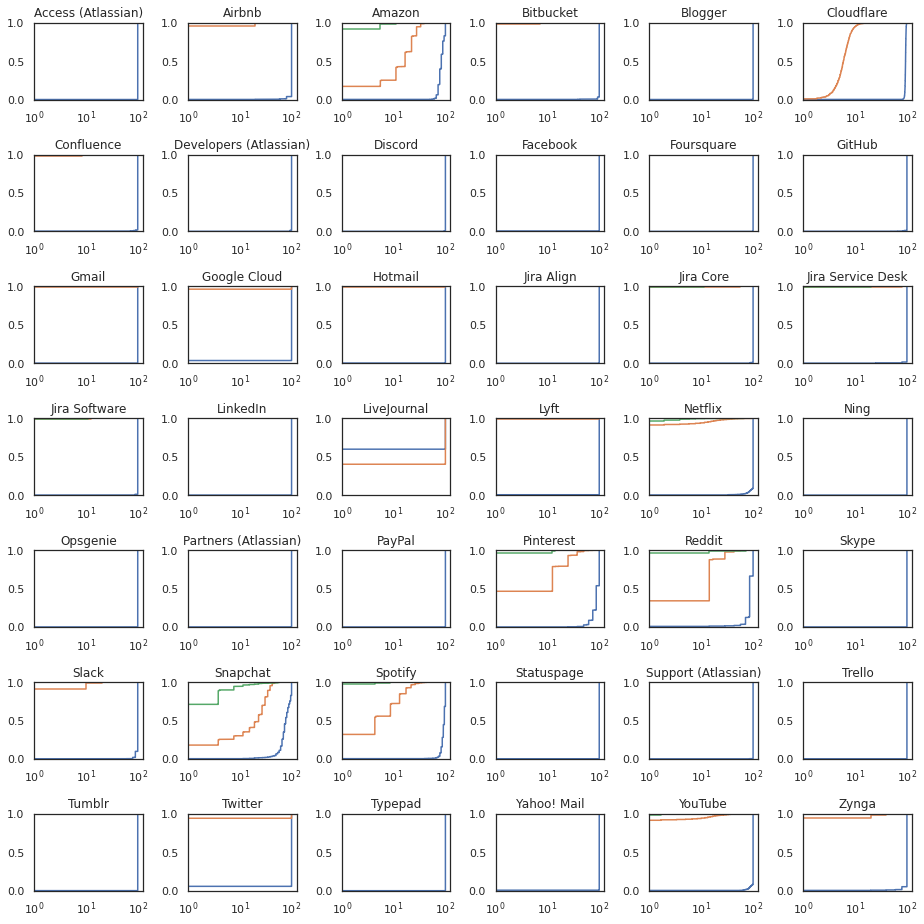

In [7]:
sns.set(rc={'figure.figsize':(13,13)})
sns.set(style='white')

n_cols = 6
fig, ax = plt.subplots(7, n_cols)
row = 0
first = False
for col, service in enumerate(timeseries['operational_pct']):
    if col % n_cols == 0 and first:
        row += 1
    first = True
    ax1 = sns.ecdfplot(data=timeseries['operational_pct'][service], ax=ax[row][col%n_cols])
    ax1 = sns.ecdfplot(data=timeseries['partial_pct'][service], ax=ax[row][col%n_cols])
    ax1 = sns.ecdfplot(data=timeseries['major_pct'][service], ax=ax[row][col%n_cols])
    ax1 = sns.ecdfplot(data=timeseries['maint_pct'][service], ax=ax[row][col%n_cols])
    ax1.set(xscale='log')
    ax1.set(xlim=(1e0, 1e2+25))
    ax1.set_ylabel('')
    ax1.set_xlabel('')
    ax1.set_title(cols[col])
fig.tight_layout()
# plt.savefig('/home/shane/Documents/thesis/output/plots/ecdf.pdf')

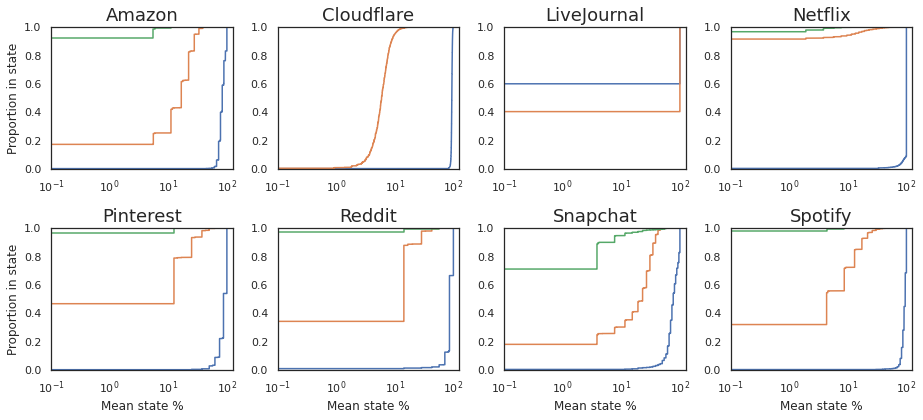

In [16]:
sns.set(rc={'figure.figsize':(13,6)})
sns.set(style='white')

n_cols = 4
fig, ax = plt.subplots(2, n_cols)
row = 0
col = 0
first = False
target_services = ['amazon','cloudflare','livejournal','netflix','pinterest','reddit','snapchat','spotify']
for num, service in enumerate(timeseries['operational_pct']):
    if service not in target_services:
        continue
    if col % n_cols == 0 and first:
        row += 1
    first = True
    ax1 = sns.ecdfplot(data=timeseries['operational_pct'][service], ax=ax[row][col%n_cols])
    ax1 = sns.ecdfplot(data=timeseries['partial_pct'][service], ax=ax[row][col%n_cols])
    ax1 = sns.ecdfplot(data=timeseries['major_pct'][service], ax=ax[row][col%n_cols])
    ax1 = sns.ecdfplot(data=timeseries['maint_pct'][service], ax=ax[row][col%n_cols])
    ax1.set(xscale='log')
#     ax1.set(yscale='log')
    ax1.set(xlim=(1e-1, 1e2+25))
    if col % n_cols != 0:
        ax1.set_ylabel('')
    else:
        pass
        ax1.set_ylabel('Proportion in state')
    if row == 0:
        ax1.set_xlabel('')
    else:
        ax1.set_xlabel('Mean state %')
    ax1.set_title(cols[num], size=18)
    col += 1
fig.tight_layout()
# plt.savefig('/home/shane/Documents/thesis/output/plots/ecdf_targeted.pdf')

/home/shane/.local/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/shane/.local/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/shane/.local/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` 

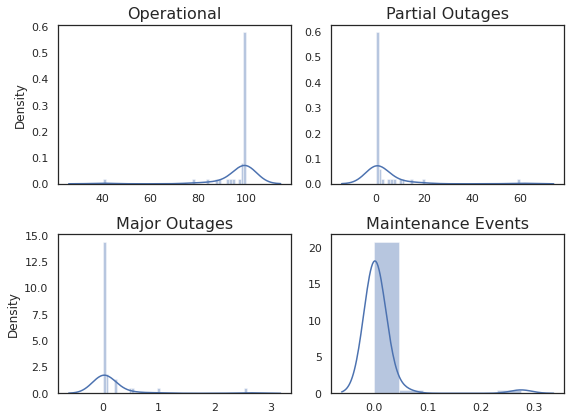

In [107]:
sns.set(rc={'figure.figsize':(8,6)})
sns.set(style='white')
fig, ax = plt.subplots(2,2)

ax1 = sns.distplot(timeseries['operational_pct'].mean(), ax=ax[0][0])
ax1.set_title('Operational', size=16)

ax1 = sns.distplot(timeseries['partial_pct'].mean(), ax=ax[0][1])
ax1.set_title('Partial Outages', size=16)
ax1.set_ylabel('')

ax1 = sns.distplot(timeseries['major_pct'].mean(), ax=ax[1][0])
ax1.set_title('Major Outages', size=16)

ax1 = sns.distplot(timeseries['maint_pct'].mean(), ax=ax[1][1])
ax1.set_title('Maintenance Events', size=16)
ax1.set_ylabel('')

fig.tight_layout()
# plt.savefig('/home/shane/Documents/thesis/output/plots/ecdf_all.pdf')

## Operational statuses

In [6]:
df_grp2 = df.reset_index().groupby(['service','date']).agg({'operational_pct': 'mean', 'partial_pct': 'mean', 'major_pct': 'mean', 'maint_pct': 'mean'})
timeseries2 = df_grp2.reset_index().pivot(index=['date'], columns=['service'], values=['operational_pct','partial_pct','major_pct','maint_pct'])

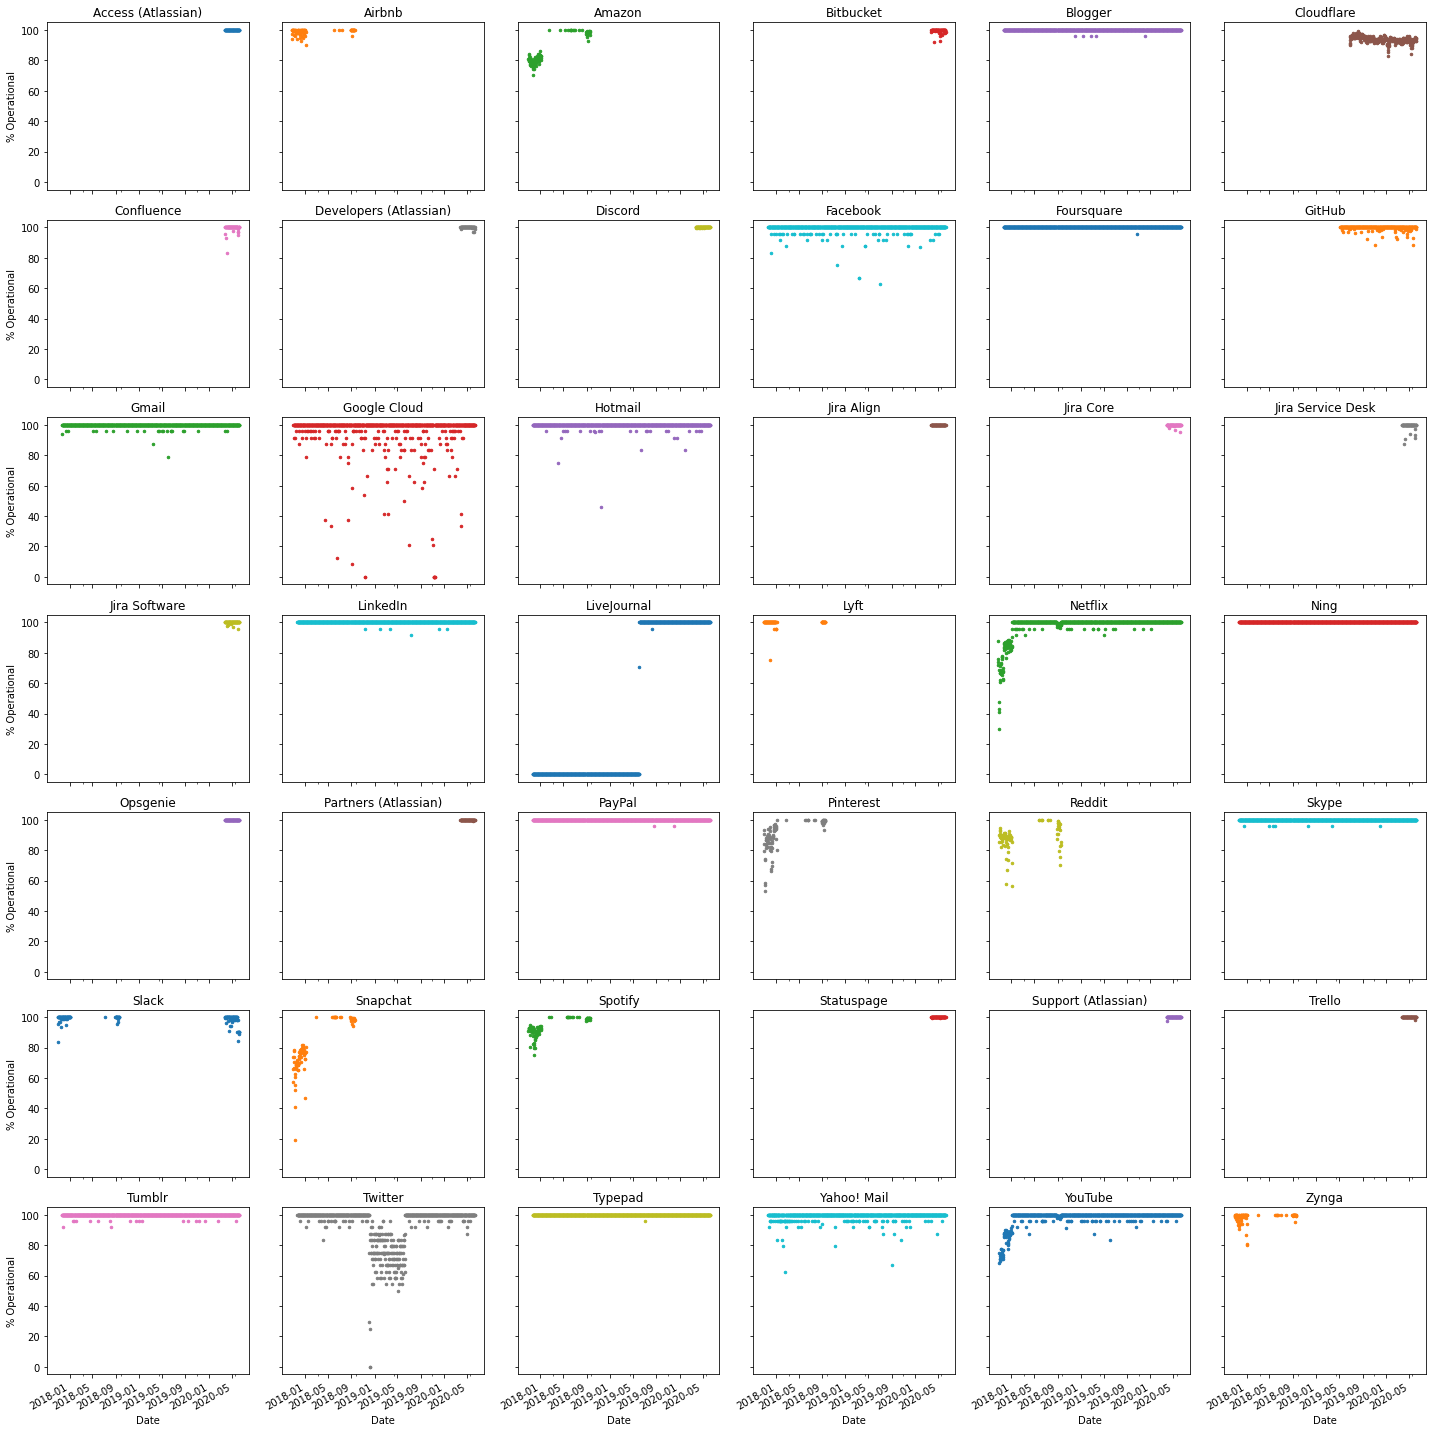

In [7]:
timeseries2.reset_index().plot(x='date', y='operational_pct', sharex=True, sharey=True, marker=".", linestyle="", markersize=5, layout = (7,6), figsize = (20, 20), subplots=True, legend=False, title=cols, xlabel='Date', ylabel='% Operational')
try:
    plt.title(fontsize=30)
    plt.ylabel(fontsize=30)
except:
    pass
plt.tight_layout()
# plt.savefig('/home/shane/Documents/thesis/output/plots/plots.pdf')

In [ ]:
dfmeans = pd.DataFrame(round(timeseries2['operational_pct'].mean(),2))
dfmeans = dfmeans.merge(round(pd.DataFrame(timeseries2['partial_pct'].mean()),2), on='service', how='left')
dfmeans = dfmeans.merge(round(pd.DataFrame(timeseries2['major_pct'].mean()),2), on='service', how='left')
dfmeans = dfmeans.merge(round(pd.DataFrame(timeseries2['maint_pct'].mean()),2), on='service', how='left')
dfmeans.index = cols
dfmeans.columns = ['Operational','Partial Outage','Major Outage','Maintenance']
print(dfmeans.to_latex())